In [19]:
from model import *
from baseline import Baseline
import networkx as nx
from metrics import *
import matplotlib.pyplot as plt
import random

In [20]:
# seed all randomness
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)


In [21]:
NUMBER_OF_SAMPLES = 1000

In [22]:
def remove_isolated_nodes(graphs):
    for graph in graphs:
        graph.remove_nodes_from(list(nx.isolates(graph)))

In [23]:
datamodule = TUDataMoudle()
datamodule.setup("fit")
training_batch = next(iter(datamodule.train_dataloader())) 
adjesency_matrixes = to_dense_adj(training_batch.edge_index, training_batch.batch)
training_samples = [nx.from_numpy_array(adjesency_matrix.detach().numpy()) for adjesency_matrix in adjesency_matrixes]

remove_isolated_nodes(training_samples)

In [24]:
model = VAE.load_from_checkpoint("model.ckpt")
baseline = Baseline(training_samples)

In [25]:
generated_samples = [nx.from_numpy_array(adjesency_matrix.cpu().detach().numpy()) for adjesency_matrix in model.sample(NUMBER_OF_SAMPLES)]
# remove_isolated_nodes(generated_samples)
generated_samples = [graph.subgraph(range(nodes_number)) for graph, nodes_number in zip(generated_samples, np.random.choice(baseline.node_number_distribution, len(generated_samples), replace=True))]

baseline_samples = baseline.sample(NUMBER_OF_SAMPLES)
# remove_isolated_nodes(baseline_samples)

In [26]:
def plot_histogram(training_samples, baseline_samples, generated_samples, title, histogram_function, bins=10):
    training_data, baseline_data, generated_data = histogram_function(training_samples), histogram_function(baseline_samples), histogram_function(generated_samples)
   
    # Increase the width of the figure
    plt.figure(figsize=(20, 5))  
    plt.suptitle(title, fontsize=16)

    # Create the first subplot and specify it to share its y-axis
    ax1 = plt.subplot(1, 3, 1)
    plt.hist(training_data, weights=[1/len(training_samples)]*len(training_data), bins=bins)
    plt.title("Training data", fontsize=12)
    
    # Create the second subplot, sharing the y-axis with the first subplot
    ax2 = plt.subplot(1, 3, 2, sharey=ax1)
    plt.hist(baseline_data, weights=[1/len(baseline_samples)]*len(baseline_data), bins=bins)
    plt.title("Baseline data", fontsize=12)
    plt.setp(ax2.get_yticklabels(), visible=False)  # Optionally hide y-axis labels for shared axis

    # Create the third subplot, sharing the y-axis with the first subplot
    ax3 = plt.subplot(1, 3, 3, sharey=ax1)
    plt.hist(generated_data, weights=[1/len(generated_samples)]*len(generated_data), bins=bins)
    plt.title("Generated data", fontsize=12)
    plt.setp(ax3.get_yticklabels(), visible=False)  # Optionally hide y-axis labels for shared axis
    
    # Apply tight layout
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])

    # Show the plot


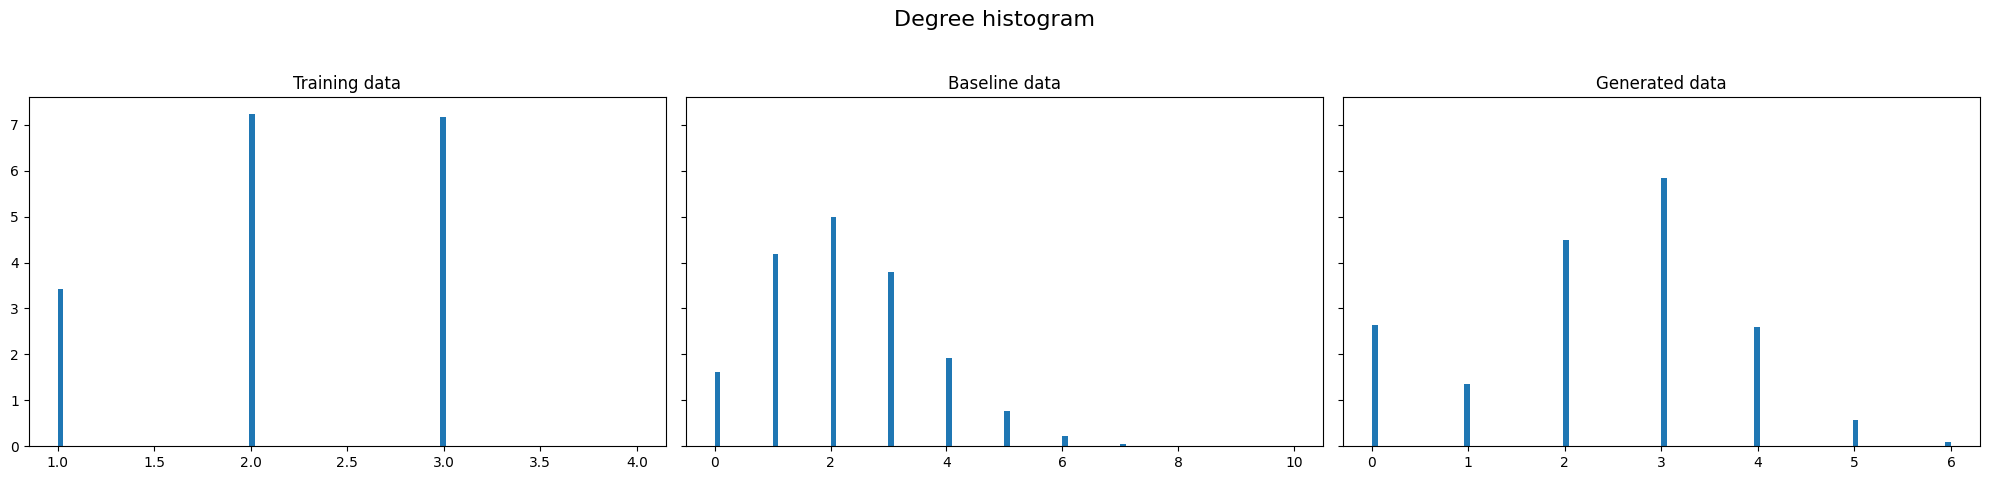

In [27]:
plot_histogram(training_samples, baseline_samples, generated_samples, "Degree histogram", degree_histogram, 100 )

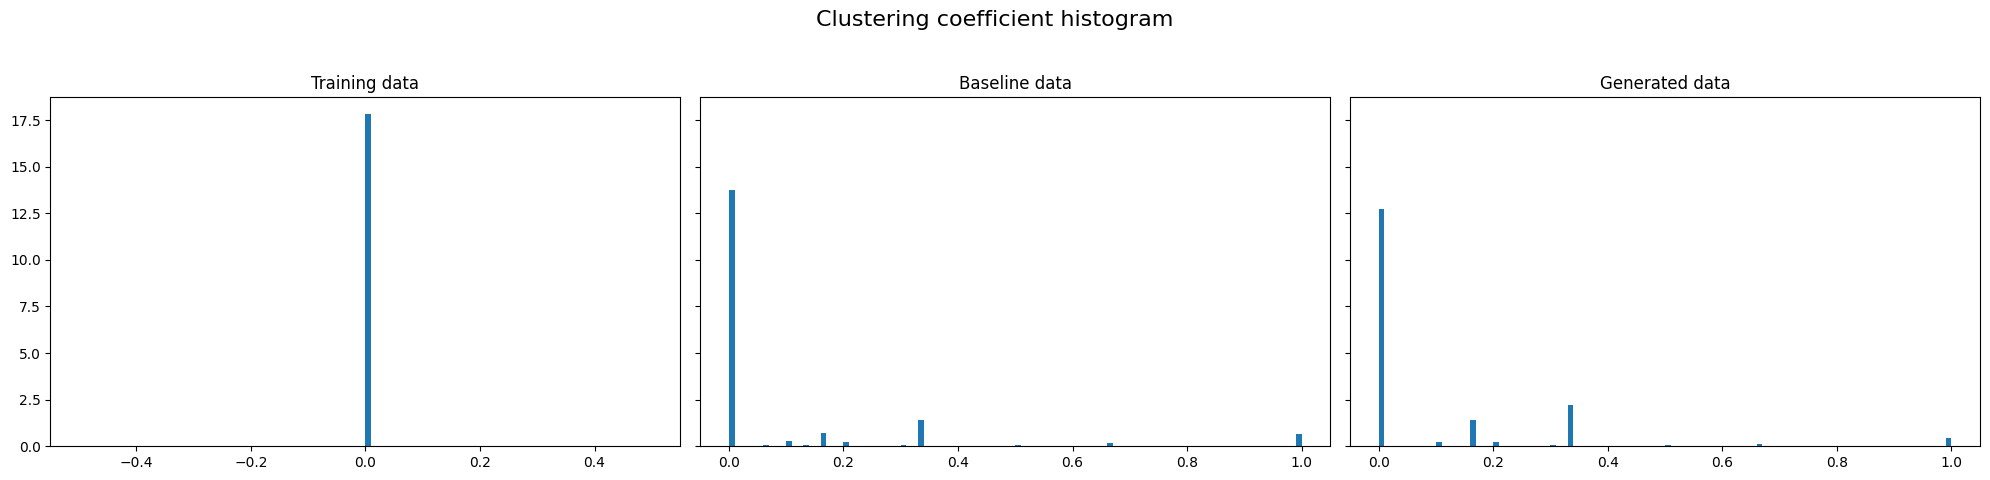

In [28]:
plot_histogram(training_samples, baseline_samples, generated_samples, "Clustering coefficient histogram", clustering_coefficient_histogram,100 )

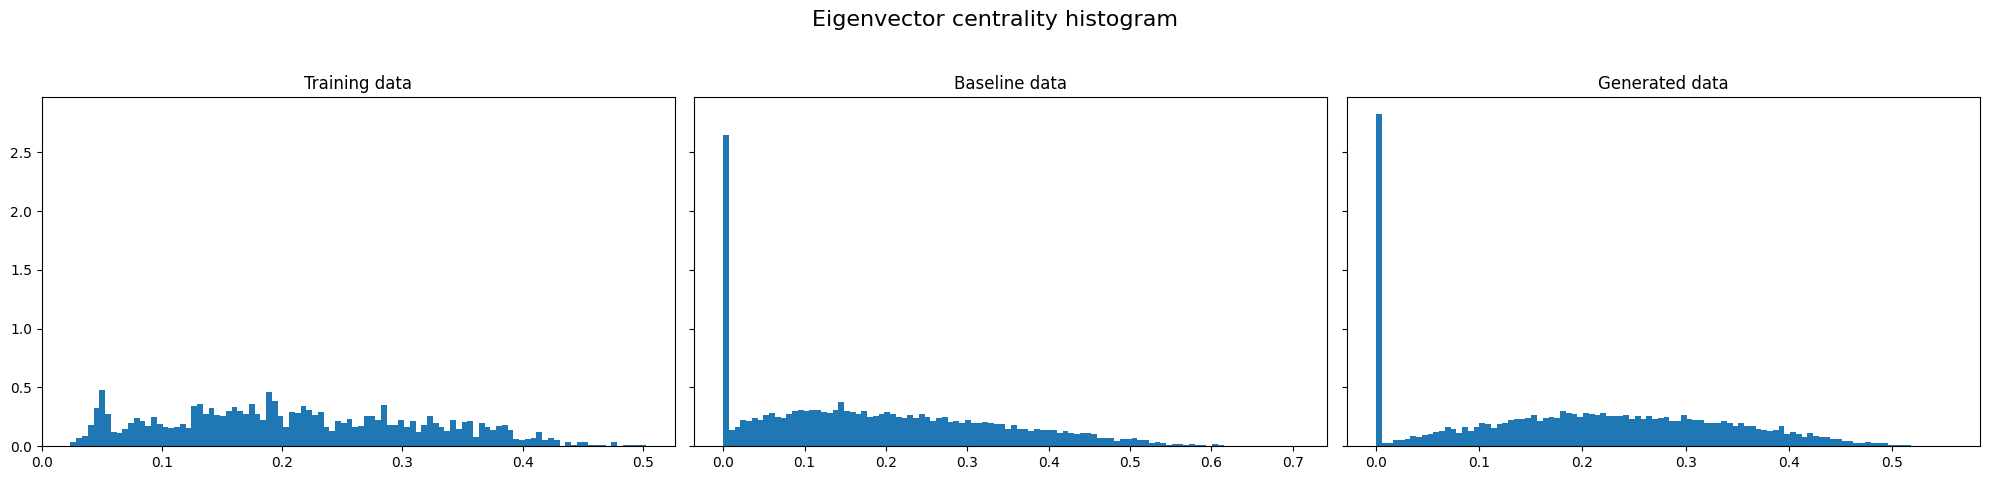

In [29]:
plot_histogram(training_samples, baseline_samples, generated_samples, "Eigenvector centrality histogram", eigenvector_centrality_histogram, 100 )

In [30]:
generated_novelty = novel(generated_samples, training_samples)
generated_uniqnes = unique(generated_samples)

print("Generated novelty: ", generated_novelty)
print("Generated uniqnes: ", generated_uniqnes)

baseline_novelty = novel(baseline_samples, training_samples)
baseline_uniqnes = unique(baseline_samples)

print("Baseline novelty: ", baseline_novelty)
print("Baseline uniqnes: ", baseline_uniqnes)


Generated novelty:  0.999
Generated uniqnes:  0.966
Baseline novelty:  1.0
Baseline uniqnes:  0.998


In [31]:
novel_unique_baseline = (baseline_novelty + baseline_uniqnes) / 2
novel_unique_generated = (generated_novelty + generated_uniqnes) / 2


In [32]:
latex_table = f"""
\\begin{{table}}[H]
\\centering
\\begin{{tabular}}{{lccc}}
\\hline
& Novel & Unique & Novel+unique \\\\
\\hline
Baseline & {baseline_novelty*100}\\% & {baseline_uniqnes*100}\\% & {novel_unique_baseline*100}\\% \\\\
Deep generative model & {generated_novelty*100}\\% & {generated_uniqnes*100}\\% & {novel_unique_generated*100}\\% \\\\
\\hline
\\end{{tabular}}
\\caption{{The percentage of the sampled graphs that are novel and unique.}}
\\label{{table:novel_unique}}
\\end{{table}}
"""

print(latex_table)


\begin{table}[H]
\centering
\begin{tabular}{lccc}
\hline
& Novel & Unique & Novel+unique \\
\hline
Baseline & 100.0\% & 99.8\% & 99.9\% \\
Deep generative model & 99.9\% & 96.6\% & 98.25\% \\
\hline
\end{tabular}
\caption{The percentage of the sampled graphs that are novel and unique.}
\label{table:novel_unique}
\end{table}



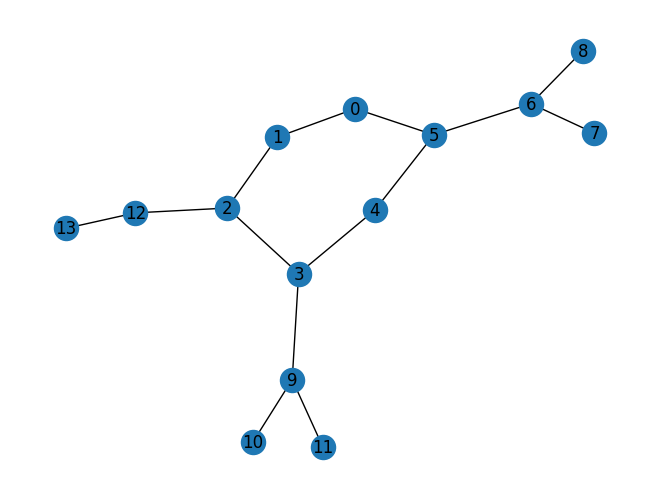

In [33]:
nx.draw(training_samples[0], with_labels=True)

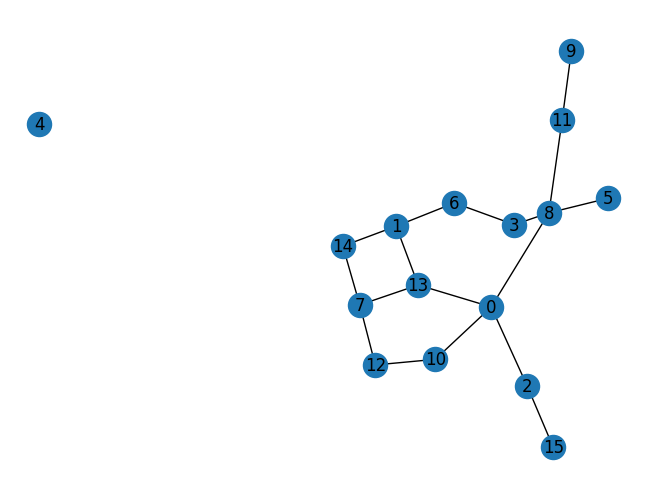

In [34]:
nx.draw(baseline_samples[0], with_labels=True)

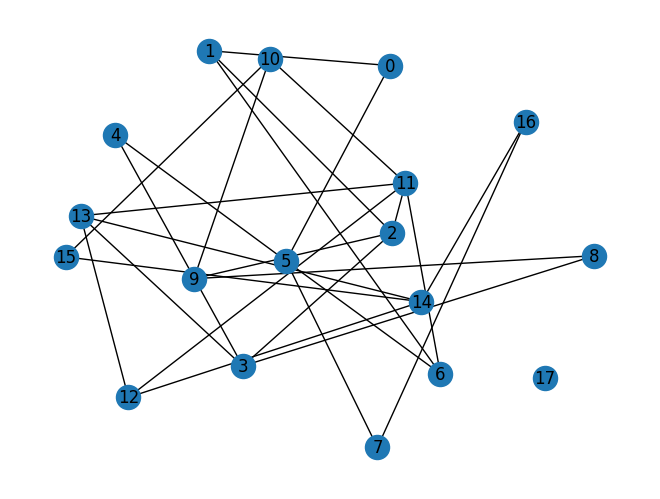

In [35]:
nx.draw(generated_samples[0], with_labels=True, pos=nx.spring_layout(generated_samples[0], k=2))


In [36]:
from einops import rearrange
prior = GaussianPrior(8)

model.to('cpu')
bernoulli_distribution = model.decoder(prior().sample(torch.tensor([1])))

# Accessing the Bernoulli distribution inside the Independent wrapper
internal_bernoulli = bernoulli_distribution.base_dist

# Accessing logits directly
retrieved_logits = internal_bernoulli.logits

# Converting logits to probabilities
probs = torch.sigmoid(retrieved_logits)
probs = rearrange(probs, 'b (c n) -> b c n', c=28)

print(probs)

result = bernoulli_distribution.sample()
result = rearrange(result, 'b (c n) -> b c n', c=28)

tensor([[[1.8317e-35, 1.0000e+00, 4.2372e-28, 4.7932e-29, 0.0000e+00,
          9.7934e-01, 1.0240e-32, 2.8237e-26, 2.2897e-37, 2.6773e-08,
          7.6852e-27, 4.1330e-19, 9.2169e-05, 4.7564e-02, 3.4272e-31,
          6.3079e-31, 1.1913e-32, 0.0000e+00, 1.2517e-28, 1.1285e-33,
          8.3041e-35, 2.1610e-34, 1.4912e-29, 3.9990e-30, 5.9865e-33,
          2.8570e-33, 7.2827e-31, 3.0456e-27],
         [1.0000e+00, 6.1428e-30, 1.0000e+00, 2.9887e-18, 1.2803e-29,
          6.1610e-33, 9.9529e-01, 2.5628e-30, 1.3507e-33, 7.3002e-32,
          9.5028e-34, 0.0000e+00, 2.1796e-06, 1.5030e-29, 2.7523e-35,
          4.7974e-30, 8.8093e-27, 5.4852e-34, 1.7029e-27, 2.4144e-28,
          0.0000e+00, 7.9966e-36, 2.3367e-29, 3.4082e-30, 9.7121e-30,
          1.1251e-30, 7.4368e-30, 9.8191e-30],
         [1.4383e-31, 1.0000e+00, 1.9479e-31, 1.0000e+00, 1.7331e-35,
          6.9409e-29, 2.0382e-14, 3.4773e-06, 0.0000e+00, 1.1272e-21,
          1.3559e-26, 2.7712e-04, 0.0000e+00, 3.0007e-30, 1.3036e-